# EDA and feature engineering

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import json
import seaborn as sns

import matplotlib.pylab as plt
plt.style.use('ggplot')

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [13]:
# Reading the datasets
# train
train_apartment = pd.read_csv('../data/apartments_train.csv')
train_building = pd.read_csv('../data/buildings_train.csv')
df_train = pd.merge(train_apartment, train_building.set_index('id'), how='left', left_on='building_id', right_on='id')

# test
test_apartment = pd.read_csv('../data/apartments_test.csv')
test_building = pd.read_csv('../data/buildings_test.csv')
df_test = pd.merge(test_apartment, test_building.set_index('id'), how='left', left_on='building_id', right_on='id')

df_all = pd.concat([df_train, df_test])
df_all['Split'] = np.where(df_all['id'] <= np.max(df_train['id']), 'Train', 'Test')

In [14]:
df_all

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,Split
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN,Train
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0,Train
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN,Train
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0,Train
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9932,33217,3.0,NaN,106.0,19.9,56.7,16.0,3.0,NaN,3.30,...,2020.0,2.0,20.0,0.0,1.0,1.0,0.0,NaN,0.0,Test
9933,33218,NaN,NaN,82.0,NaN,NaN,3.0,3.0,NaN,NaN,...,2021.0,2.0,20.0,0.0,1.0,1.0,1.0,NaN,NaN,Test
9934,33219,NaN,NaN,49.3,NaN,NaN,15.0,1.0,NaN,0.00,...,2016.0,2.0,24.0,0.0,1.0,1.0,0.0,1.0,1.0,Test
9935,33220,NaN,NaN,38.8,10.5,15.1,14.0,1.0,NaN,3.30,...,2019.0,NaN,14.0,1.0,1.0,1.0,0.0,1.0,NaN,Test


In [15]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['price'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print('Train columns \n', list(df_train.columns))
print('Test columns \n', list(df_test.columns))

Number of Training Examples = 23285
Number of Test Examples = 9937

Training X Shape = (23285, 34)
Training y Shape = 23285

Test X Shape = (9937, 33)
Test y Shape = 9937

Train columns 
 ['id', 'seller', 'price', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 'constructed', 'material', 'stories', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute', 'heating']
Test columns 
 ['id', 'seller', 'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 'windows_court', 'windows_street', 'balconies', 'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude', 'longitude', 'district', 'street', 'address', 'constructed', 'material', 'stories', 'el

In [16]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

## Apartments

In [18]:
print(f'Loaded {len(train_apartment)} apartments')
with open('../data/apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(train_apartment, apartments_meta)

Loaded 23285 apartments


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID for apartment,#unique=23285
seller,categorical,8830,The type of apartment seller,"Agents(1895), Company(4768), Developer(6185), Owner(1607)"
price,real,0,The listed price of the apartment (TARGET),"mean=23556173.5, std=52643927.8, min=900000.0, max=2600000000.0"
area_total,real,0,Total area of the apartment,"mean=74.5, std=58.7, min=9.3, max=2181.0"
area_kitchen,real,4721,Total kitchen area in the apartment,"mean=12.6, std=6.6, min=1.0, max=100.0"
area_living,real,3882,Total living space area in the apartment,"mean=38.7, std=31.4, min=0.0, max=900.0"
floor,integer,0,Primary building floor of the apartment,"mean=9.0, std=8.3, min=1.0, max=95.0"
rooms,integer,0,Number of rooms in the apartment,"mean=2.2, std=1.1, min=1.0, max=6.0"
layout,categorical,17642,Overal apartment layout,"Adjacent(241), Adjacent_isolated(465), Isolated(4937)"
ceiling,real,11093,Ceiling height in the apartment,"mean=3.3, std=10.8, min=0.0, max=340.0"


## Buildings

In [21]:
print(f'Loaded {len(train_building)} buildings')
with open('../data/buildings_meta.json') as f: 
    buildings_meta = json.load(f)
train_building.head()
describe_data(train_building, buildings_meta)

Loaded 6791 buildings


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID of building for joining with apartments,#unique=6791
new,boolean,227,Whether it is an old or new building,"False(6141), True(423)"
latitude,real,0,Latitude coordinate of building,"mean=55.7, std=0.1, min=55.2, max=56.0"
longitude,real,0,Longitude coordinate of building,"mean=37.6, std=0.2, min=36.9, max=38.0"
district,categorical,1,Administriative district within Moscow,"Central(637), East(956), North(593), North-East(630), North-West(553), Novomoskovsk(344), South(758), South-East(672), South-West(900), Troitsk(146), West(535), Zelenograd(66)"
street,string,0,Bulding street name,#unique=1682
address,string,0,Building address (within street),#unique=1851
constructed,integer,479,Year when the building was constructed,"mean=1985.8, std=24.3, min=1855.0, max=2023.0"
material,categorical,1165,Primary building material used in building,"Block(679), Bricks(1226), Monolith(1312), Monolithic_brick(19), Panel(2384), Stalin_project(2), Wood(4)"
stories,integer,0,Total number of floors in the building,"mean=13.0, std=7.0, min=1.0, max=95.0"


## Missing values

Number of missing price entries in train data: 0
Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33


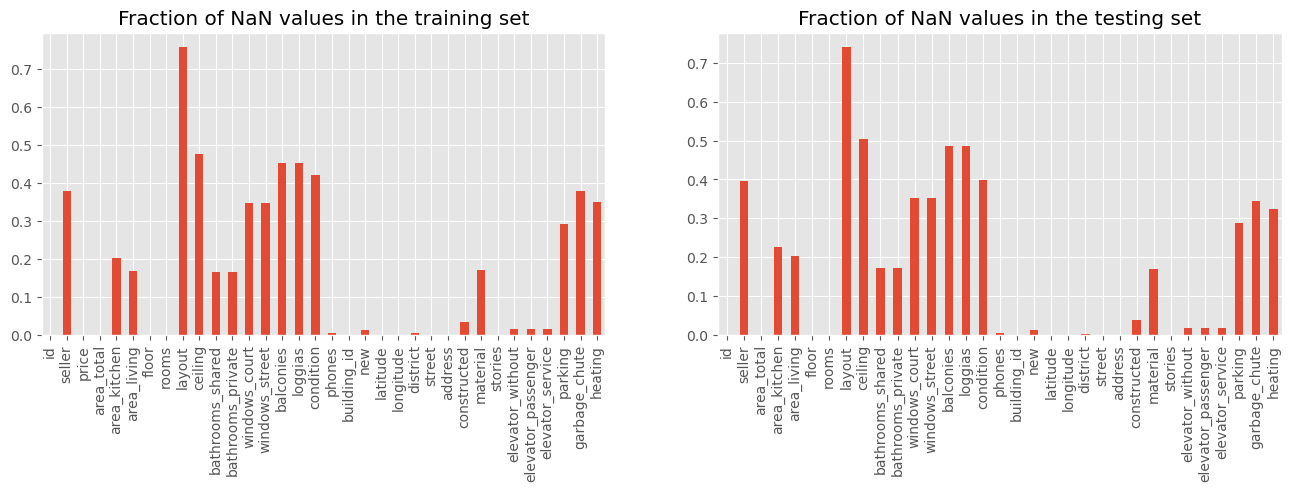

In [24]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {df_train.price.isna().sum()}')
print(f'Training set features with any missing value: {df_train.isna().any().sum()}/{df_train.shape[1]}')
print(f'Testing set features with any missing value: {df_test.isna().any().sum()}/{df_test.shape[1]}')
df_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
df_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

## Price distribution

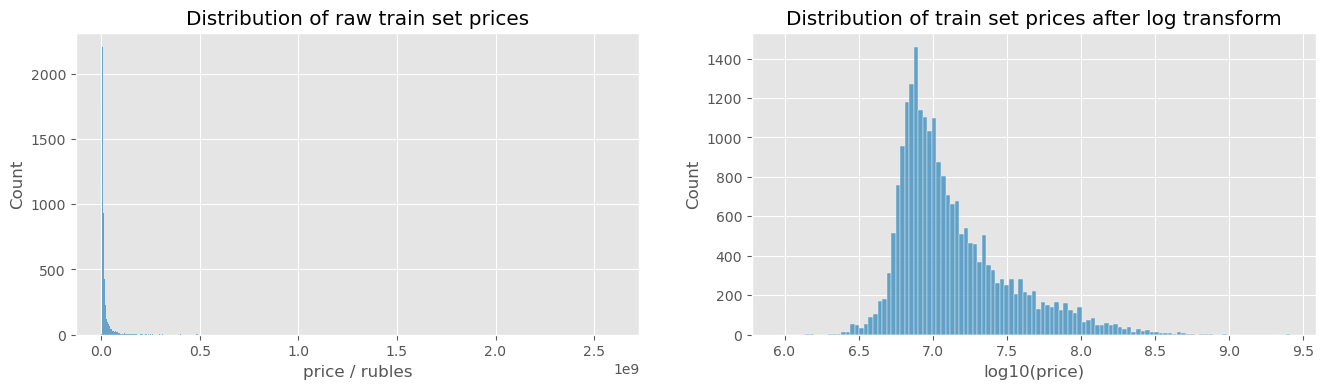

In [28]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.histplot(df_train.price.rename('price / rubles'), ax=ax1)
ax1.set_title('Distribution of raw train set prices');
sns.histplot(np.log10(df_train.price).rename('log10(price)'), ax=ax2)
ax2.set_title('Distribution of train set prices after log transform');

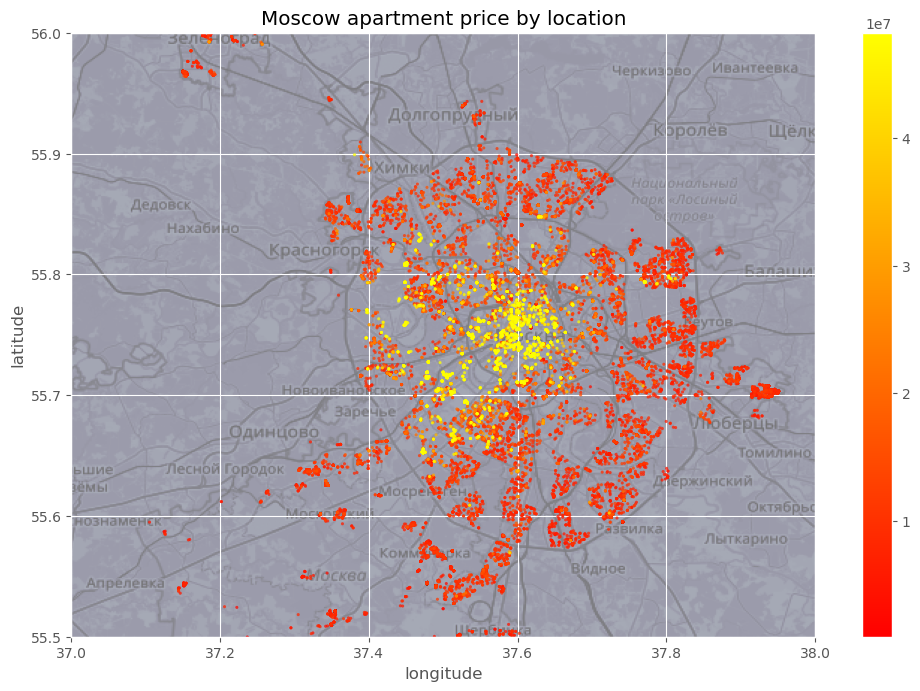

In [30]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('../data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(df_train);

## Feature engineering

In [31]:
def cat_plot(data,title,p):
    sns.catplot(x="rooms", y="price", data=data,palette = p)
    plt.title('No. of Bedrooms vs Price in '+ title,size=16)
    plt.gcf().set_size_inches(6,8)
    plt.show()

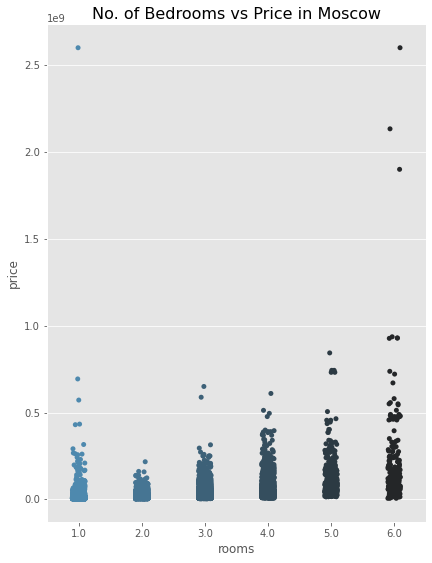

ValueError: min() arg is an empty sequence

In [46]:
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
moscow = sns.dark_palette(custom_colors[0], reverse=True)
cat_plot(df_train[(np.abs(stats.zscore(df_train['rooms'])) < 4)],'Moscow',moscow)
cat_plot(df_train[(np.abs(stats.zscore(df_train['rooms'])) >= 4)],'Moscow',['red'])